### Data Cleaning and Preprocessing 

In [1]:
# Reading the dataset
import pandas as pd
data = pd.read_csv('G:/RKS/Projects/bank_customer_churn_analysis/churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [2]:
# Dropping the unnecessary columns
data = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [3]:
# Cheking for missing values in the dataset
data.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Note that in this dataset there are no missing values.

In [4]:
# Cheking the types of data in columns
data.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [5]:
# Appying the label encoding technique on categorical columns
data['Geography'] = data['Geography'].astype('category').cat.codes
data['Gender'] = data['Gender'].astype('category').cat.codes
data.dtypes

CreditScore          int64
Geography             int8
Gender                int8
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [6]:
# Specifying the features and target
X = data.drop(columns = ['Exited'])
y = data.Exited

#### Handling Highly Correlated Features

In [7]:
import numpy as np

# Calculating correlation of features to one another
corr = X.corr().abs()
corr = corr.fillna(0)

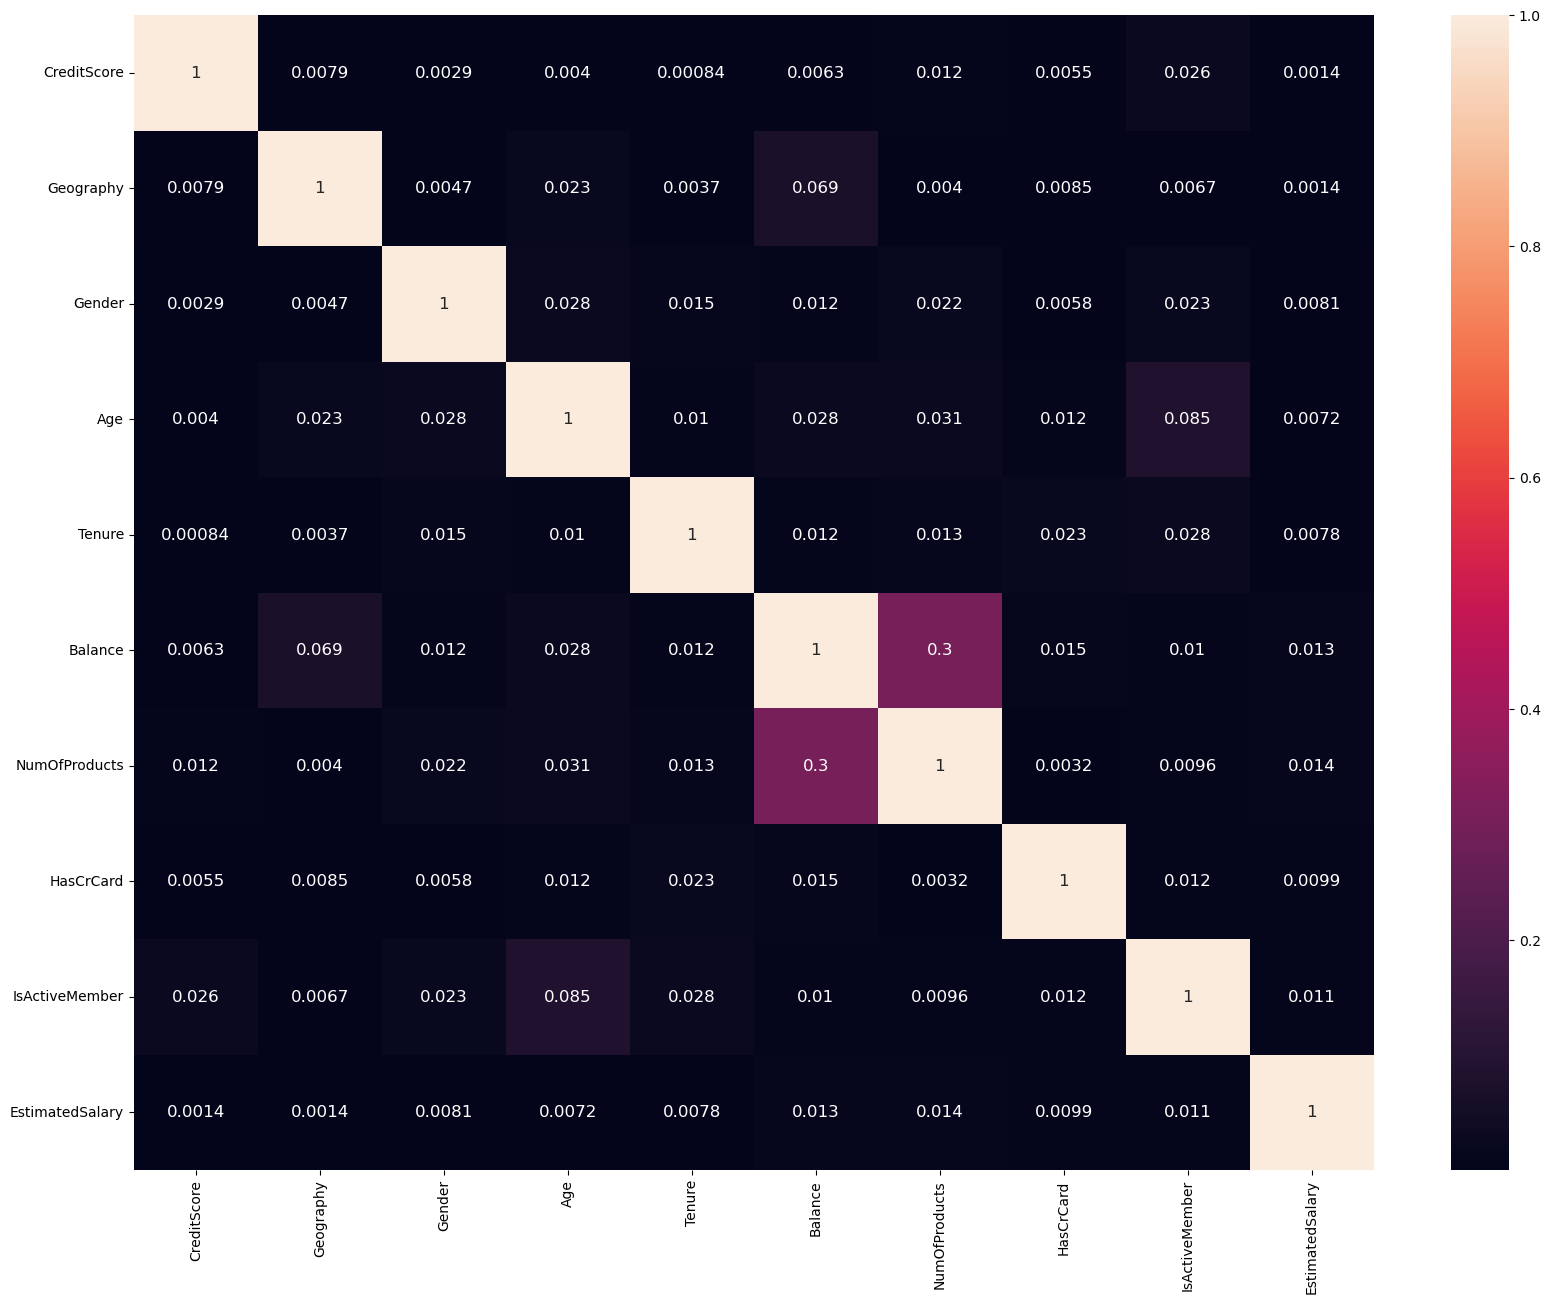

In [8]:
# Plotting the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("corr.png", dpi=100)

In [9]:
# Selecting the upper triangle of the correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
# Finding the index of feature columns with correlation greater than 0.9
Drop = [column for column in upper.columns if any(upper[column] > 0.9)][:-1]
# Eliminating one of each pair of features with correlation greater than 0.90
X = X.drop(X[Drop], axis=1)

Note that in the case of this dataset, there were no pair of features with correlation greater than 0.9. Thus, no feature has been eliminated.

### Model Selection and Hyperparameter Optimization utilizing Five Classification Algorithms

In [10]:
# Splitting the data into train and test sets
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [11]:
from sklearn.pipeline import Pipeline 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Specifying the models and hyperparameter sets for each

pipe1 = Pipeline([['sc',sc],['clf1',KNeighborsClassifier()]])
params_1 = [{'clf1__n_neighbors': [1,3, 5, 7, 9,11,13,15],'clf1__leaf_size': [10, 15, 20, 25],'clf1__weights': ['uniform', 'distance']}]

pipe2 = Pipeline([['sc',sc],['clf2',LinearSVC()]])
params_2 = {'clf2__penalty':['l1','l2'],'clf2__C': [0.001, 0.01, 0.1, 1, 10],'clf2__loss':('hinge','squared_hinge')}

pipe3 = Pipeline([['sc',sc],['clf3',LogisticRegression(random_state=42)]])
params_3={'clf3__penalty':['l1','l2'],'clf3__C':np.logspace(-4, 4, 20)}

pipe4 = Pipeline([['sc',sc],['clf4',DecisionTreeClassifier(random_state=42)]])
params_4 = {'clf4__max_depth':[3,4,5,6,7,8,9,10,12,15,20,30,45,60,90,130],'clf4__criterion':['gini','entropy']}

pipe5 = Pipeline([['sc',sc],['clf5',RandomForestClassifier()]])
params_5 = {'clf5__min_samples_leaf': [1, 2, 4], 'clf5__n_estimators': [50,200, 700],'clf5__max_features': ['auto', 'sqrt', 'log2'],'clf5__min_samples_split': [2, 5, 10]}

classifiers = ['KNN','LinearSVC' ,'Logistic Regression', 'Decision Tree','RandomForestClassifier']

In [12]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

for clf_name, clf, params in zip(classifiers, [pipe1,pipe2,pipe3,pipe4,pipe5], [params_1,params_2,params_3,params_4,params_5]):
    # Doing the grid search on each model
    grid_search=GridSearchCV(clf, params, n_jobs=-1, verbose=0,cv=5)
    grid_search.fit(X_train, y_train)
    print('─'*100)
    print('\033[1mGrid search on %s\033[0m'%clf_name)
    # Getting the best score
    best_score = grid_search.best_score_
    print('The best score: %.2f'%best_score)
    # Getting the set of best parameters
    best_parameters = grid_search.best_params_
    print('The best set of parameters:')
    for param_name in best_parameters.keys():
        print('\t%s: %s'%(param_name,best_parameters[param_name]))
    print('\n\033[1m5-fold cross-validation\033[0m')
    print('\t\t\t      train  test')
    estimator = clf.set_params(**best_parameters)
    # 5-fold cross-validation on train and test sets using the best paramters set
    for scoring in ['accuracy','f1','roc_auc','precision','recall']:
        scores_train=cross_val_score(estimator=estimator, X=X_train,y=y_train.ravel(), cv=5, scoring=scoring)
        scores_test=cross_val_score(estimator=estimator, X=X_test,y=y_test.ravel(), cv=5, scoring=scoring)
        print(f"\t{scoring:20}  {scores_train.mean():.2f}   {scores_test.mean():.2f}")

────────────────────────────────────────────────────────────────────────────────────────────────────
Grid search on KNN
The best score: 0.84
The best set of parameters:
	clf1__leaf_size: 10
	clf1__n_neighbors: 11
	clf1__weights: distance

5-fold cross-validation
			      train  test
	accuracy              0.84   0.83
	f1                    0.46   0.34
	roc_auc               0.81   0.77
	precision             0.73   0.71
	recall                0.33   0.23
────────────────────────────────────────────────────────────────────────────────────────────────────
Grid search on LinearSVC
The best score: 0.80
The best set of parameters:
	clf2__C: 10
	clf2__loss: squared_hinge
	clf2__penalty: l2

5-fold cross-validation
			      train  test
	accuracy              0.80   0.80
	f1                    0.18   0.13
	roc_auc               0.75   0.76
	precision             0.61   0.49
	recall                0.11   0.09
──────────────────────────────────────────────────────────────────────────────────────

#### Conclusion on Model Selection
Based on the results of the roc_auc score, which is a commonly used metric for binary classification, the RandomForestClassifier appears to be the optimal model selection. This is supported by its high roc_auc scores of 0.85 and 0.84 on the train and test sets respectively. Additionally, the best set of parameters for this model have been identified.

### Feature Selection using Three Different Methods

In [14]:
from sklearn.feature_selection import mutual_info_classif , SelectKBest
from sklearn.feature_selection import RFE

# Using the RandomForestClassifier to get the feature importances in order to rank the features
rf = RandomForestClassifier()
rf.fit(X, y)
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print ('Selected top features using feature importance in a RandomForestClassifier:')
print (list(feature_importances.index[:4]))
print (' ')

# Defining the feature selection method using mutual info classification in order to get the top 4, then fitting the data
selector = SelectKBest(score_func=mutual_info_classif)
selector.fit_transform(X, y)

# Getting the indices of the top 4 features and printing the names
cols = selector.get_support(indices=True)
print ('Selected features having top mutual information scores:')
print (list(X_train.iloc[:,cols].columns)[:4])
print (' ')
# Using recursive feature elimination method in order to get the top 4 features
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=4)
rfe.fit(X, y)

# Getting the indices of the top 4 features and printing the names
top_4 = np.array(list(X_train.columns))[rfe.support_]
print ('Selected features by Recrucive Feature Elimination:')
print(top_4)

Selected top features using feature importance in a RandomForestClassifier:
['Age', 'EstimatedSalary', 'CreditScore', 'Balance']
 
Selected features having top mutual information scores:
['CreditScore', 'Geography', 'Gender', 'Age']
 
Selected features by Recrucive Feature Elimination:
['CreditScore' 'Age' 'Balance' 'EstimatedSalary']


### Overfit and Underfit Analysis

In [15]:
from sklearn.model_selection import learning_curve
# Using the learning_curve module with LogisticRegression as the model
log_reg = LogisticRegression()
lrn_crv = learning_curve(log_reg, X, y, scoring='roc_auc', cv=5, train_sizes=np.array([0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9,1.0]))
lrn_crv

(array([ 800, 1600, 2400, 3200, 4000, 4800, 5600, 6400, 7200, 8000]),
 array([[0.7199187 , 0.69001551, 0.69001551, 0.69001551, 0.69001551],
        [0.68671781, 0.57574386, 0.57574386, 0.57574386, 0.57574386],
        [0.54970841, 0.67365436, 0.68183905, 0.68183905, 0.68183905],
        [0.66191309, 0.66746101, 0.68028641, 0.68028641, 0.68028641],
        [0.66279234, 0.66756176, 0.6690245 , 0.5701091 , 0.5701091 ],
        [0.55604384, 0.66882937, 0.67076037, 0.66826176, 0.66826176],
        [0.67180814, 0.67550819, 0.67702531, 0.66637515, 0.66637515],
        [0.66928668, 0.67278907, 0.67399103, 0.66415013, 0.56339616],
        [0.66969874, 0.67312261, 0.67403073, 0.66505191, 0.67306233],
        [0.66952974, 0.6724435 , 0.68411939, 0.66528831, 0.67197436]]),
 array([[0.68090452, 0.66624175, 0.66069305, 0.69333124, 0.67018174],
        [0.67544062, 0.55911913, 0.55245384, 0.59621255, 0.58266741],
        [0.57418065, 0.66846025, 0.66211975, 0.69366439, 0.67059355],
        [0.6724584

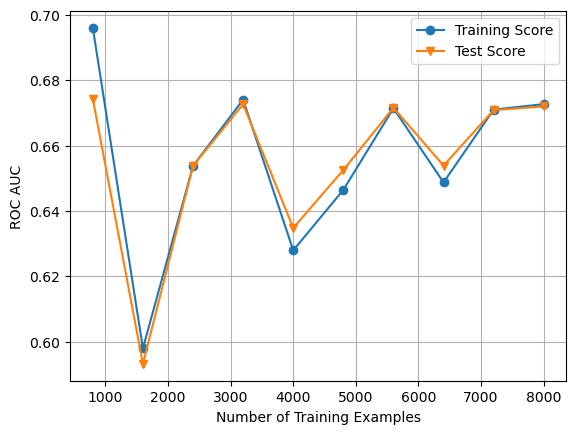

In [16]:
import matplotlib.pyplot as plt
trains, tests = [], []
for i,j in zip(lrn_crv[1],lrn_crv[2]):
    trains.append(np.mean(i))
    tests.append(np.mean(j))
# Plotting the ROC AUC curve for different number of training examples for the purpose of overfit/underfit analysis 
plt.plot(lrn_crv[0],trains, '-o')
plt.plot(lrn_crv[0],tests, '-v')
plt.grid(True)
plt.xlabel('Number of Training Examples')
plt.ylabel('ROC AUC')
plt.legend(['Training Score', 'Test Score'])
plt.show()

#### Interpretation
As seen in the figure above, if we split the data evenly into train and test splits (50%; each), we would not have a good score for neither of the train and test sets, and we will have an underfit due to the slightly better score of the test set. 

On the other hand, if we consider around 10% of the data for the training set, we would have an overfit model, since the model will memorize the small amount of data; thus it will not perform well on the test set.
Note that in the figure above, if around 70% would be considered as the training set, the model, in this case logistic regression, would perform well.
This also validates our initial train_test_split above before using the five algorithms.